**Idx-aware GFN for better sample diversity**

First experiments in the hypergrid toy environment

**Sanity check for a GFN that is not parameterized with the idx**

In [1]:
# Imports
import torch
import wandb
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np

from gfn import LogitPBEstimator, LogitPFEstimator, LogZEstimator
from gfn.envs import HyperGrid, IdxAwareHyperGrid
from gfn.losses import TBParametrization, TrajectoryBalance
from gfn.samplers import DiscreteActionsSampler, TrajectoriesSampler
from gfn.utils import validate

device_str = "cuda" if torch.cuda.is_available() else "cpu"

/home/mila/v/vincent.quirion/.conda/envs/gfnenv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Then use a GFN that partitions the state space perfectly

In [2]:
batch_size = batch_size = 4
n_validation_samples = batch_size* 25 * 100
wandb.init(project="8x8")

env = IdxAwareHyperGrid(ndim=2, height=8, reward="8x8", preprocessor_name="OneHot", device_str=device_str)
# env = HyperGrid(ndim=4, height=8, preprocessor_name="OneHot", device_str=device_str)

logit_PF = LogitPFEstimator(env=env, module_name="IdxAwareNeuralNet", batch_size=batch_size)
# logit_PF = LogitPFEstimator(env=env, module_name="NeuralNet")

logit_PB = LogitPBEstimator(
    env=env,
    module_name="IdxAwareNeuralNet",
    # module_name="NeuralNet",
    torso=logit_PF.module.torso,  # To share parameters between PF and PB
    batch_size=batch_size,
    embedding_layer=logit_PF.module.idx_embedding_layer, # To share parameters between PF and PB
)
logZ = LogZEstimator(torch.tensor(0.0))

logit_PF.module.to(torch.device(device_str))
logit_PB.module.to(torch.device(device_str))


parametrization = TBParametrization(logit_PF, logit_PB, logZ)

actions_sampler = DiscreteActionsSampler(estimator=logit_PF)
trajectories_sampler = TrajectoriesSampler(env=env, actions_sampler=actions_sampler)

loss_fn = TrajectoryBalance(parametrization=parametrization)

params = [
    {
        "params": [
            val for key, val in parametrization.parameters.items() if key != "logZ"
        ],
        "lr": 0.001,
    },
    {"params": [parametrization.parameters["logZ"]], "lr": 0.1},
]
optimizer = torch.optim.Adam(params)

n_per_idxs = 16

visited_terminating_states = (
    env.States.from_batch_shape((0,))
)
states_visited = 0
for i in (pbar := tqdm(range(10000))):
    idxs = torch.arange(batch_size, device=env.device).repeat(n_per_idxs)
    trajectories = trajectories_sampler.sample(n_trajectories=batch_size * n_per_idxs, idxs=idxs)
    # trajectories = trajectories_sampler.sample(n_trajectories=batch_size * n_per_idxs)

    optimizer.zero_grad()
    loss = loss_fn(trajectories, idxs)
    # loss = loss_fn(trajectories)
    loss.backward()
    optimizer.step()
    
    if visited_terminating_states is not None:
        visited_terminating_states.extend(trajectories.last_states)

    states_visited += len(trajectories)
    to_log = {"loss": loss.item(), "states_visited": states_visited}
    wandb.log(to_log, step=i)

    if i % 25 == 0:
        validation_info = validate(
            env, parametrization, n_validation_samples, visited_terminating_states
        )
        pbar.set_postfix({"loss": loss.item(), "l1 dist": validation_info["l1_dist"]})
        wandb.log(validation_info, step=i)

trajectories_sampler3 = trajectories_sampler

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: vincent-quirion. Use `wandb login --relogin` to force relogin


 74%|███████▍  | 7424/10000 [06:34<02:16, 18.83it/s, loss=0.00121, l1 dist=0.00759] 


KeyboardInterrupt: 

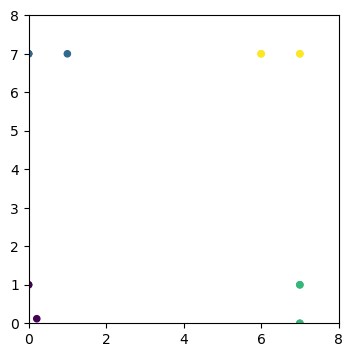

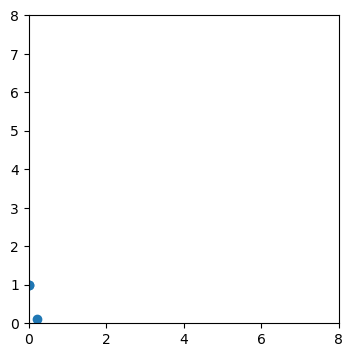

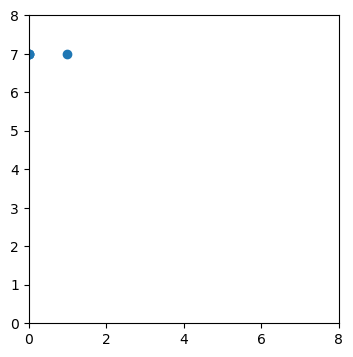

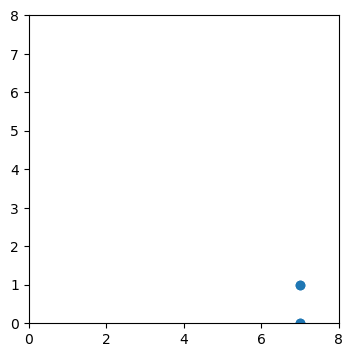

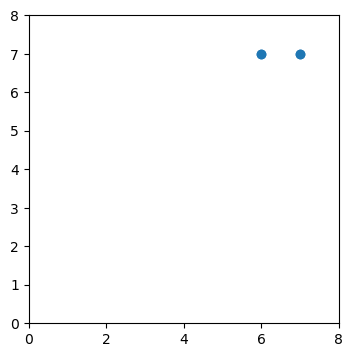

In [13]:
# Set the figure size
plt.rcParams["figure.figsize"] = [4, 4]

n_per_idx = 4

trajectories = trajectories_sampler3.sample(n_trajectories=4 * n_per_idx, idxs=torch.tensor([0] * n_per_idx + [1] * n_per_idx + [2] * n_per_idx + [3] * n_per_idx, dtype=torch.int, device=env.device))


data = trajectories.last_states.states_tensor.cpu().numpy()
# Adding noise to see more points
data = data.astype("float64")
data[0] += np.random.uniform(low=-0.25, high=0.25, size=data[0].size)
data[1] += np.random.uniform(low=-0.25, high=0.25, size=data[1].size)


plt.scatter(x=data[:, 0], y=data[:, 1], c=[0.25]*n_per_idx + [0.5] * n_per_idx + [0.75] * n_per_idx + [1] * n_per_idx, s=[20] * 4 * n_per_idx)
plt.xlim(0, 8)
plt.ylim(0, 8)
plt.plot()
plt.show()

plt.scatter(x=data[:, 0][:n_per_idx], y=data[:, 1][:n_per_idx])
plt.xlim(0, 8)
plt.ylim(0, 8)
plt.plot()
plt.show()


plt.xlim(0, 8)
plt.ylim(0, 8)
plt.scatter(x=data[:, 0][n_per_idx:n_per_idx*2], y=data[:, 1][n_per_idx:n_per_idx*2])
plt.plot()
plt.show()

plt.xlim(0, 8)
plt.ylim(0, 8)
plt.scatter(x=data[:, 0][n_per_idx*2:n_per_idx*3], y=data[:, 1][n_per_idx*2:n_per_idx*3])
plt.plot()
plt.show()

plt.xlim(0, 8)
plt.ylim(0, 8)
plt.scatter(x=data[:, 0][n_per_idx*3:n_per_idx*4], y=data[:, 1][n_per_idx*3:n_per_idx*4])
plt.plot()
plt.show()